# ICP Analysis

Code authored by: Shaw Talebi

### imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

from utils import load_clean_data

### functions

In [2]:
def plot_logistic_regression_coefficients(classifier, feature_names, target_name, 
                                        figsize=(12, 8), show_values=True, 
                                        positive_color='blue', negative_color='red', 
                                        alpha=0.7):
    """
    Plot logistic regression coefficients as a horizontal bar chart.
    
    Parameters:
    -----------
    classifier : LogisticRegression
        Trained logistic regression classifier
    feature_names : list
        List of feature names corresponding to the coefficients
    target_name : str
        Name of the target variable for the plot title
    figsize : tuple, default=(12, 8)
        Figure size (width, height)
    show_values : bool, default=True
        Whether to show coefficient values on the bars
    positive_color : str, default='blue'
        Color for positive coefficients
    negative_color : str, default='red'
        Color for negative coefficients
    alpha : float, default=0.7
        Transparency level for the bars
    
    Returns:
    --------
    matplotlib.figure.Figure
        The matplotlib figure object
    """
    
    # Get coefficients
    coefficients = classifier.coef_[0]  # coef_ is 2D, so we take the first row
    
    # Create a dataframe for easier manipulation
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients
    })
    
    # Sort by absolute coefficient value for better visualization
    coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)
    
    # Create the bar plot
    fig, ax = plt.subplots(figsize=figsize)
    colors = [negative_color if x < 0 else positive_color for x in coef_df['coefficient']]
    bars = ax.bar(range(len(coef_df)), coef_df['coefficient'], color=colors, alpha=alpha)
    
    # Customize the plot
    ax.set_xlabel('Features')
    ax.set_ylabel('Coefficient Value')
    ax.set_title(f'Logistic Regression Coefficients for {target_name}')
    ax.set_xticks(range(len(coef_df)))
    ax.set_xticklabels(coef_df['feature'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on bars if requested
    if show_values:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.03),
                   f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    return fig

### load data

In [3]:
df = load_clean_data("students_activity_reviews")

In [4]:
df.shape

(92, 44)

### feature and target selection

In [5]:
predictor_list = []
for column_name in df.columns:
    # course join reason
    if "cluster_" in column_name:
        predictor_list.append(column_name)
        
    # if "company_size" in column_name and df[column_name].dtype == int:
    #     predictor_list.append(column_name)

    if "job_category" in column_name and df[column_name].dtype == int:
        predictor_list.append(column_name)

    if "source" in column_name and df[column_name].dtype == int:
        predictor_list.append(column_name)

print(predictor_list)

['job_category_entrepreneur', 'job_category_ic', 'job_category_leader', 'job_category_manager', 'job_category_student', 'job_category_unknown', 'source_enrolled_(free)', 'source_lightning_lesson', 'source_started_payment', 'source_uploaded_to_waitlist', 'source_waitlist', 'course_join_question_cluster_1', 'course_join_question_cluster_2', 'course_join_question_cluster_3', 'course_join_question_cluster_4', 'course_join_question_cluster_5']


In [6]:
target_list = ['rating_exists', 'rating_gte_10']

print(target_list)

['rating_exists', 'rating_gte_10']


### train models

In [7]:
# define predictor and target dfs
X = df[predictor_list]
y = df[target_list]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
clf_dict = {}

for target in target_list:
    # pick out target data
    y_train_temp = y_train[target]
    y_test_temp = y_test[target]
    
    # train logistic regression model
    clf = LogisticRegression(
        random_state=0, 
        class_weight='balanced',
        C=0.5,
    ).fit(X_train, y_train_temp)


    # append classifier to list
    clf_dict[target] = clf

### evaluate model performance

In [9]:
# create table with rows for each target and columns for train/test accuracy/ROC AUC/F1
results_data = []

for i, target in enumerate(target_list):
    # get the corresponding classifier
    clf = clf_dict[target]
    
    # pick out target data
    y_train_temp = y_train[target]
    y_test_temp = y_test[target]
    
    # calculate train metrics
    train_acc = clf.score(X_train, y_train_temp)
    train_pred = clf.predict(X_train)
    train_pred_proba = clf.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train_temp, train_pred_proba)
    train_f1 = f1_score(y_train_temp, train_pred)
    
    # calculate test metrics
    test_acc = clf.score(X_test, y_test_temp)
    test_pred = clf.predict(X_test)
    test_pred_proba = clf.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test_temp, test_pred_proba)
    test_f1 = f1_score(y_test_temp, test_pred)
    
    # calculate deltas (train - test)
    acc_delta = abs(train_acc - test_acc)
    roc_auc_delta = abs(train_roc_auc - test_roc_auc)
    f1_delta = abs(train_f1 - test_f1)
    
    # store results
    results_data.append({
        'Target': target,
        'Train_Accuracy': round(train_acc, 3),
        'Test_Accuracy': round(test_acc, 3),
        '|Accuracy_Delta|': round(acc_delta, 3),
        'Train_ROC_AUC': round(train_roc_auc, 3),
        'Test_ROC_AUC': round(test_roc_auc, 3),
        '|ROC_AUC_Delta|': round(roc_auc_delta, 3),
        'Train_F1': round(train_f1, 3),
        'Test_F1': round(test_f1, 3),
        '|F1_Delta|': round(f1_delta, 3)
    })

# create results dataframe
results_df = pd.DataFrame(results_data).sort_values(['|F1_Delta|'])
results_df

,Target,Train_Accuracy,Test_Accuracy,|Accuracy_Delta|,Train_ROC_AUC,Test_ROC_AUC,|ROC_AUC_Delta|,Train_F1,Test_F1,|F1_Delta|
1,rating_gte_10,0.766,0.786,0.020,0.789,0.759,0.029,0.651,0.625,0.026
0,rating_exists,0.750,0.679,0.071,0.793,0.603,0.191,0.680,0.526,0.154


In [10]:
# save to .csv
new_filename = 'data/3-results/LR_results.csv'
results_df.to_csv(new_filename, index=False)

### analyze features

#### per model

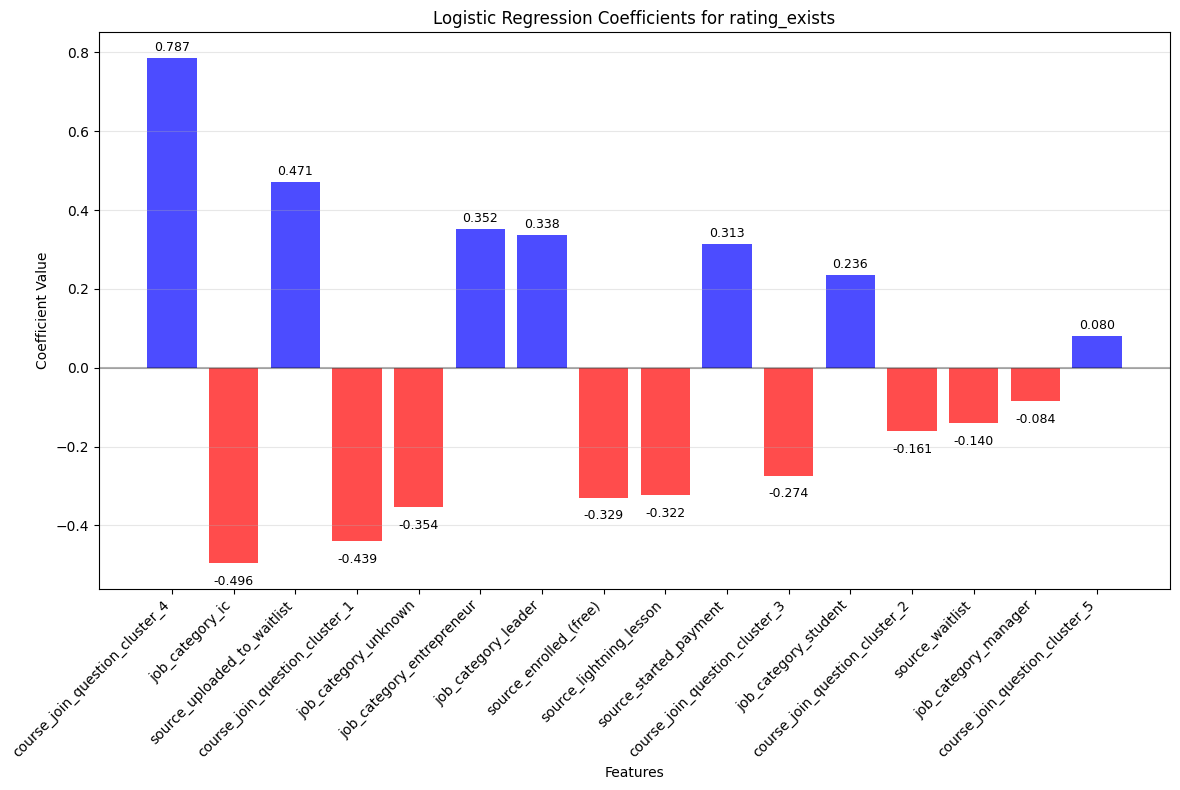

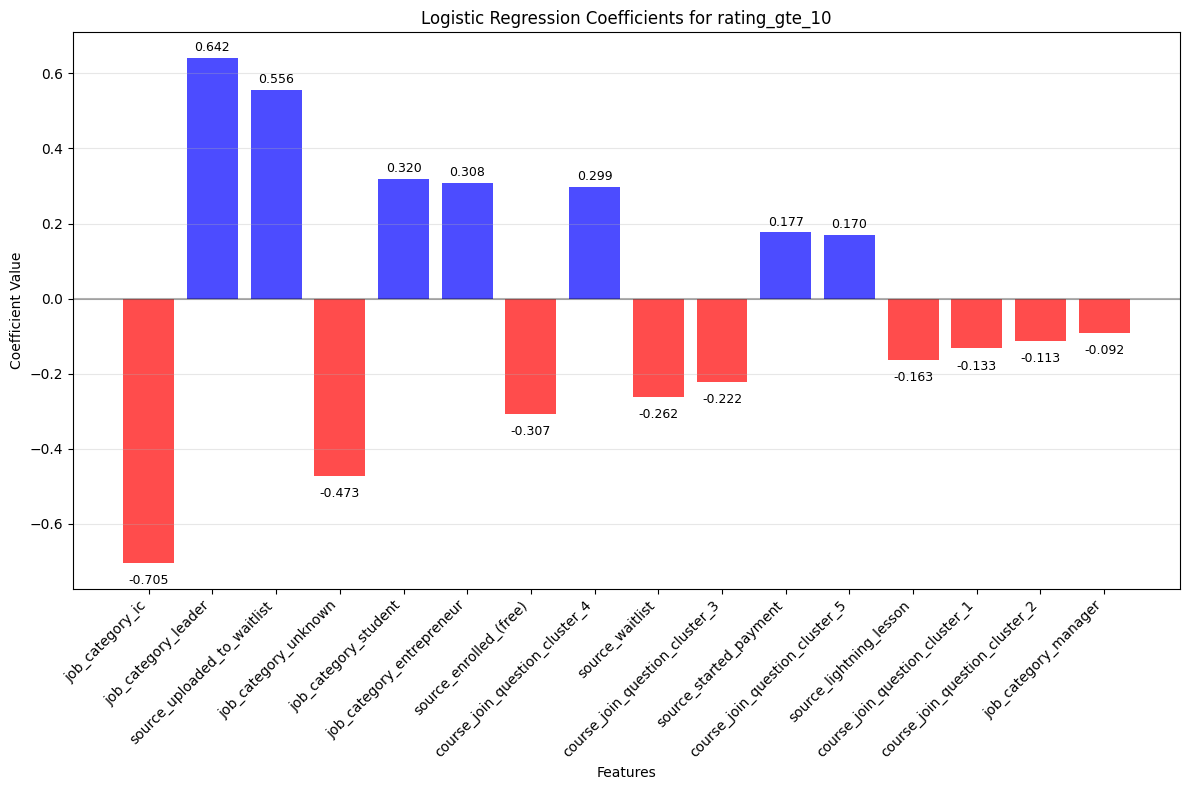

In [11]:
# plot coefs
for target in target_list:
    fig = plot_logistic_regression_coefficients(
        classifier=clf_dict[target],
        feature_names=predictor_list,
        target_name=target
    )
    
    # Save to file
    fig.savefig(f'data/3-results/LR_coefs_{target}.png', dpi=300, bbox_inches='tight')

#### aggregated

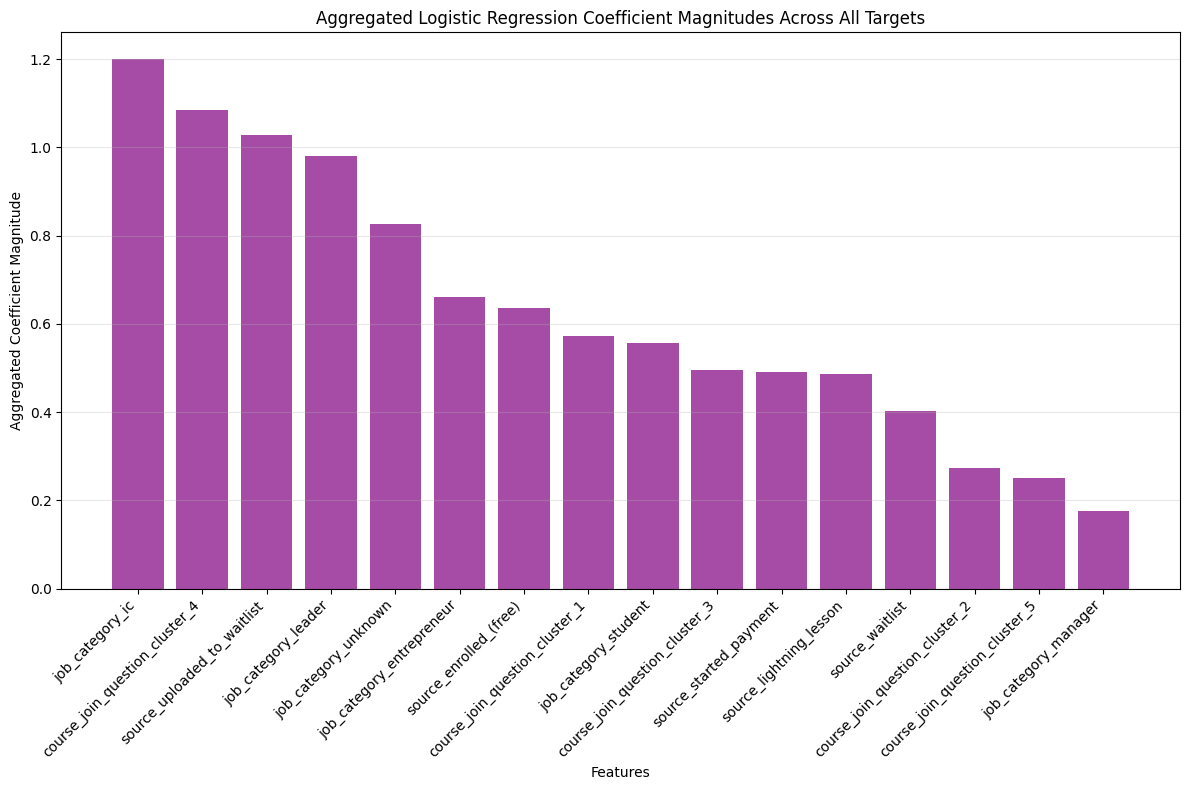

In [12]:
# aggregate coefficent magnitudes
coef_mag_arr = np.zeros([len(predictor_list),])
for target in target_list:
    coef_mag_arr = coef_mag_arr + abs(clf_dict[target].coef_)

# Create bar plot for aggregated coefficient magnitudes
fig, ax = plt.subplots(figsize=(12, 8))

# Sort features by coefficient magnitude for better visualization
coef_df = pd.DataFrame({
    'feature': predictor_list,
    'coefficient_magnitude': coef_mag_arr[0]  # Take first row since coef_ is 2D
})
coef_df = coef_df.sort_values('coefficient_magnitude', ascending=False)

# Create the bar plot
bars = ax.bar(range(len(coef_df)), coef_df['coefficient_magnitude'], 
              color='purple', alpha=0.7)

# Customize the plot
ax.set_xlabel('Features')
ax.set_ylabel('Aggregated Coefficient Magnitude')
ax.set_title('Aggregated Logistic Regression Coefficient Magnitudes Across All Targets')
ax.set_xticks(range(len(coef_df)))
ax.set_xticklabels(coef_df['feature'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save to file
fig.savefig('data/3-results/LR_coefs_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()